In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
# 添加缺失的vwap字段（如果未提供）
if 'vwap' not in df.columns:
    df['vwap'] = df['turnover'] / df['volume']

In [4]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [5]:
def calculate_volume_weighted_upper_shadow(df, rsi_window=14, volume_window=20):
    """
    量能加权上影线因子
    金融学原理：
    1. 高成交量区域的上影线代表真实阻力位，反转信号更强
    2. 量能标准化可消除市场波动带来的偏差
    3. RSI过滤确保信号发生在有效反转区域
    """
    # 计算RSI
    df['rsi'] = ta.rsi(df['close'], length=rsi_window)
    
    # 计算量能比率 (当前成交量/20日均量)
    df['vol_ma'] = df['volume'].rolling(volume_window).mean()
    df['vol_ratio'] = df['volume'] / df['vol_ma']
    
    # 计算基础因子
    max_open_close = np.maximum(df['open'], df['close'])
    upper_shadow = (df['high'] - max_open_close) / df['open']
    
    # 在超买区(RSI>70)应用量能加权
    return np.where(
        df['rsi'] > 70,
        upper_shadow * np.log1p(df['vol_ratio']),  # 对数缩放避免极端值
        upper_shadow
    )

# 因子测试

In [6]:
evaluator.set_factor(
    factor_data_or_func=calculate_volume_weighted_upper_shadow,
    factor_name='calculate_volume_weighted_upper_shadow'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.015733
   Rank_IC (Spearman): 0.012324
📊 信息比率:
   IR: 0.409031
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130726
   因子列: calculate_volume_weighted_upper_shadow
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


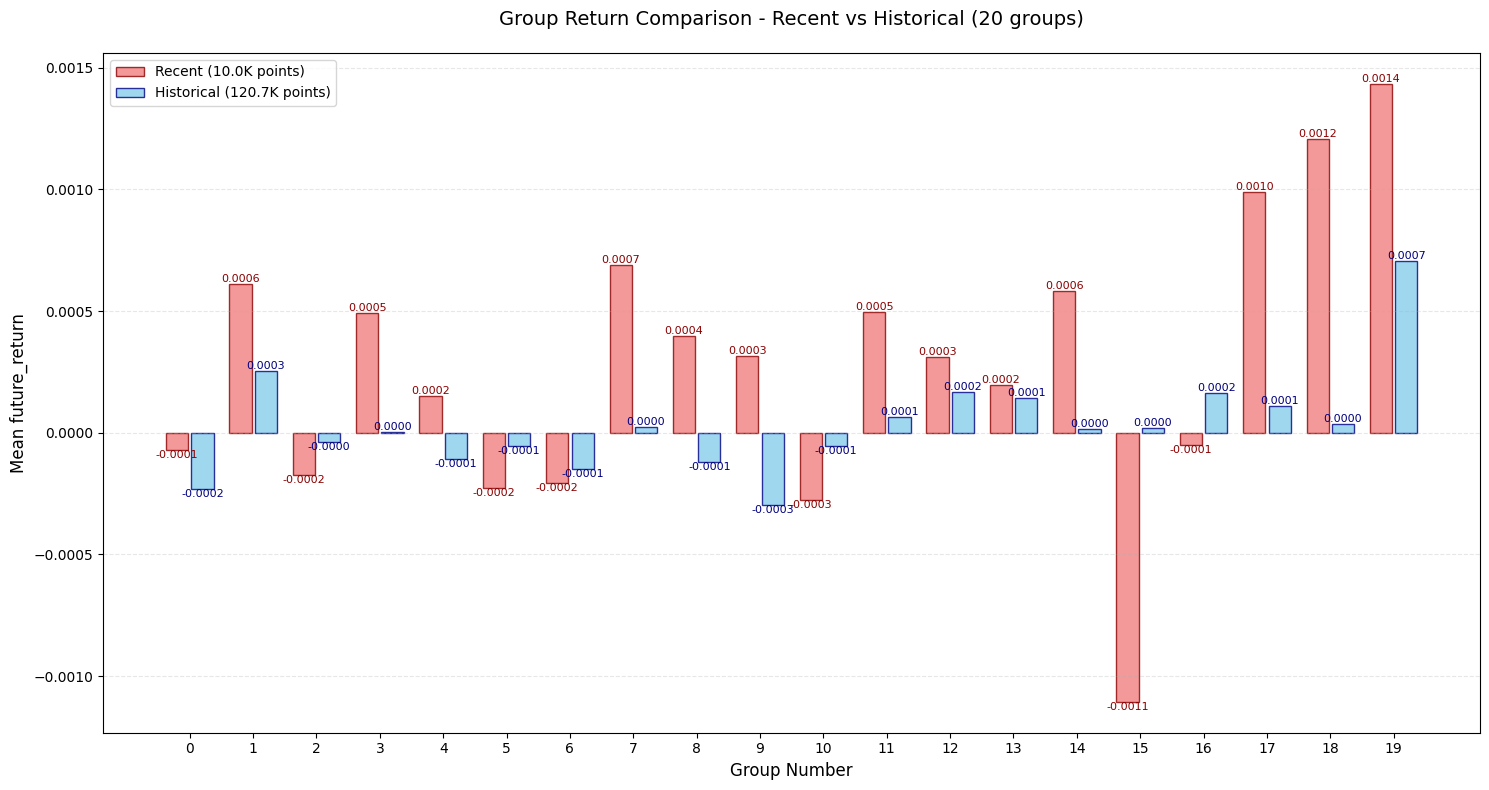

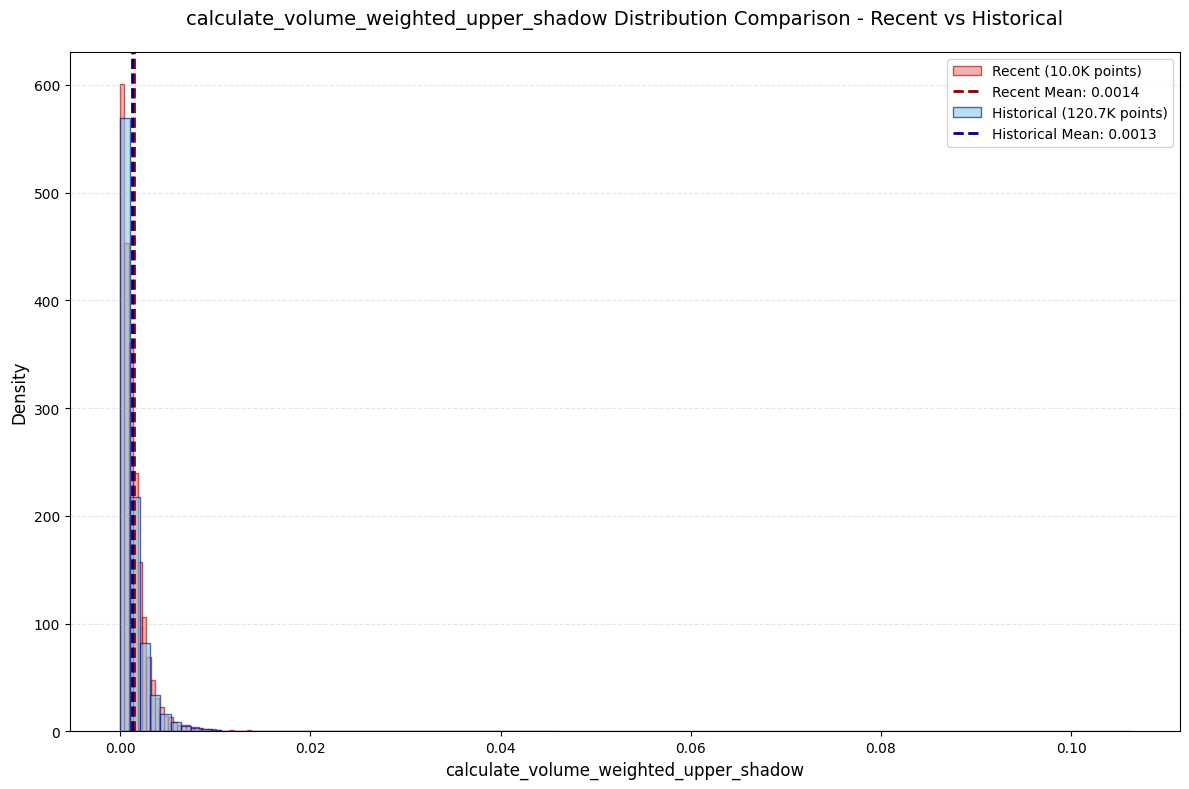

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [7]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)